## Caution: important experiment, please do not adjust

The contents within this file are for running a publication-quality experiment and producing the associated figures and results. As such, it is finely tuned for specific high-quality graphics using the `primary.mplstyle` file. Please do not adjust. If you need to replicate results on your local system, please create a new notebook and copy contents from here.

In [1]:
import sys
sys.path.append('../..')  # Expose top level program access

import re
import time
import pickle
import logging
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from sklearn.covariance import EllipticEnvelope
from mpl_toolkits.mplot3d import Axes3D
from functools import reduce
from pathlib import Path
from utils import tools, metrics, supported_preprocessing_transforms
from modules.aae_base_module import AAEBaseModule
from modules.vae_base_module import VAEBaseModule
from models import supported_models
from datasets import supported_datamodules
from scipy.stats import gaussian_kde
from utils.dtypes import *

logging.getLogger("matplotlib").setLevel(logging.WARNING)  # Suppress verbose font warnings from matplotlib

In [2]:
# import configurations and paths to logged models
root = Path.cwd().parents[1]
log_path = root / 'logs' / 'LunarAnalogueDataModule'
paths_to_archived_models = list(Path(log_path).glob('**/archive_v*'))

# filter the models that don't provide structured latent representations
for i, p in enumerate(paths_to_archived_models.copy()):
    if not re.search('VAE|AAE', str(p)):
        paths_to_archived_models.remove(p)

print('Found archived models:\n------')
print('\n'.join([f'{p.parent.name}/{p.name}' for p in paths_to_archived_models]))

Found archived models:
------
BaselineVAE/archive_v2_2021-05-06
BaselineVAE/archive_v1_2021-05-06
BaselineAAE/archive_v1_2021-05-06


In [3]:
from experiments.helpers import load_modules

module_catalog, datamodule, _ = load_modules(paths_to_archived_models)

Loading state dict for: BaselineVAE/archive_v2_2021-05-06
Loading state dict for: BaselineVAE/archive_v1_2021-05-06
Loading state dict for: BaselineAAE/archive_v1_2021-05-06


In [4]:
### Collect scores and labels on test set for all models and save to a dictionary
result_catalog = {}

for model_type, model_variants in module_catalog.items():
    start_time = time.time()
    
    for model_name, module in model_variants.items():
        
        latent_vecs = []
        test_novelty_scores = []
        test_novelty_labels = []
        short_name = model_type + '-' + model_name.split('_')[1]
        print(f'------\n{short_name}\n------')
        
        if short_name not in result_catalog:
            result_catalog[short_name] = {
                'latent_vecs': [],
                'scores':      [], 
                'labels':      []
            }
        
        # Set the model/components to evaluation mode
        if 'AAE' in model_type:
            module.encoder.eval()
            module.decoder.eval()
        else:
            module.model.eval()

        with torch.no_grad():
            for batch_nb, batch in enumerate(datamodule.test_dataloader()):

                result = module.test_step(batch, batch_nb)
                
                # Populate results
                latent_vecs.extend(result['images']['batch_lt'].cpu().numpy())
                test_novelty_scores.extend(result['scores'])
                test_novelty_labels.extend(result['labels'].cpu().numpy())                
                print(f'[BATCH {batch_nb}] Mean score: {np.mean(result["scores"])}')
                    
        result_catalog[short_name]['latent_vecs'] = latent_vecs
        result_catalog[short_name]['scores'] = test_novelty_scores
        result_catalog[short_name]['labels'] = test_novelty_labels
        print(f'{short_name} Time: {time.time() - start_time:.2f} s\n')

------
BaselineVAE-v2
------
[BATCH 0] Mean score: 0.6344375014305115
[BATCH 1] Mean score: 0.6344892978668213
[BATCH 2] Mean score: 0.6870218515396118
[BATCH 3] Mean score: 0.6637244820594788
[BATCH 4] Mean score: 0.6943281888961792
[BATCH 5] Mean score: 0.6596382856369019
[BATCH 6] Mean score: 0.6120131015777588
[BATCH 7] Mean score: 0.6415998339653015
[BATCH 8] Mean score: 0.7066675424575806
[BATCH 9] Mean score: 0.6918644905090332
[BATCH 10] Mean score: 0.6964203119277954
[BATCH 11] Mean score: 0.6856534481048584
[BATCH 12] Mean score: 0.671383261680603
[BATCH 13] Mean score: 0.7120749950408936
[BATCH 14] Mean score: 0.7091120481491089
[BATCH 15] Mean score: 0.7013727426528931
[BATCH 16] Mean score: 0.6871374845504761
[BATCH 17] Mean score: 0.6592769622802734
[BATCH 18] Mean score: 0.6689265370368958
[BATCH 19] Mean score: 0.6719409227371216
[BATCH 20] Mean score: 0.7094860076904297
[BATCH 21] Mean score: 0.723008394241333
[BATCH 22] Mean score: 0.7216706275939941
[BATCH 23] Mean s

2021-07-30 14:46:18,005 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-07-30 14:46:19,638 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:19,639 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:19,640 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:19,640 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:19,640 - DEBUG - STREAM b'IDAT' 149 74
2021-07-30 14:46:19,642 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:19,643 - DEBUG - STREAM b'PLTE' 41 39
2021-07-30 14:46:19,643 - DEBUG - STREAM b'tRNS' 92 12
2021-07-30 14:46:19,644 - DEBUG - STREAM b'pHYs' 116 9
2021-07-30 14:46:19,644 - DEBUG - STREAM b'IDAT' 137 43
2021-07-30 14:46:19,646 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:19,647 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:19,648 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:19,648 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:19,649 - DEBUG - STREAM b'IDAT' 149 67
2021-07-30 14:46:19,650 - DEBUG - STREAM b'IHDR' 16 13
2021-07

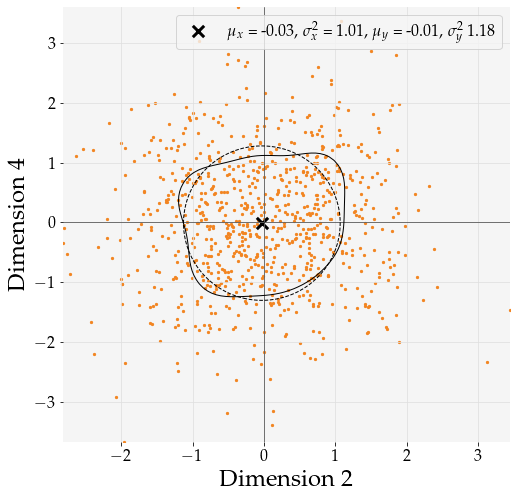

2021-07-30 14:46:20,245 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:20,245 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:20,246 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:20,246 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:20,246 - DEBUG - STREAM b'IDAT' 149 181
2021-07-30 14:46:20,255 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:20,256 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:20,256 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:20,257 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:20,257 - DEBUG - STREAM b'IDAT' 149 137
2021-07-30 14:46:20,259 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:20,259 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:20,260 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:20,260 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:20,260 - DEBUG - STREAM b'IDAT' 149 133
2021-07-30 14:46:20,262 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:20,263 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:20,263 - DEBUG - STREAM b'tRNS' 101 15


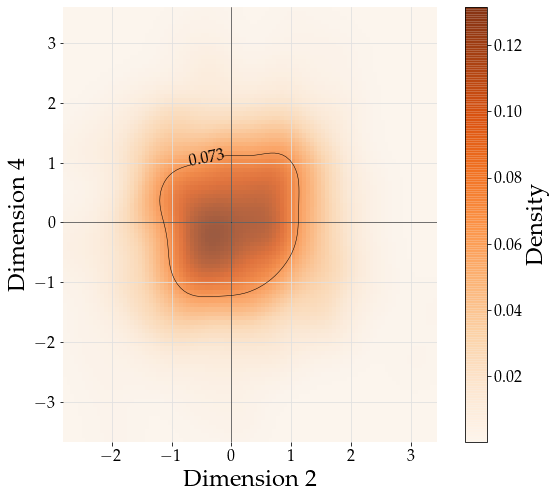

2021-07-30 14:46:20,868 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:20,869 - DEBUG - STREAM b'PLTE' 41 42
2021-07-30 14:46:20,870 - DEBUG - STREAM b'tRNS' 95 13
2021-07-30 14:46:20,870 - DEBUG - STREAM b'pHYs' 120 9
2021-07-30 14:46:20,870 - DEBUG - STREAM b'IDAT' 141 55
2021-07-30 14:46:20,992 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:20,993 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:20,994 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:20,994 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:20,994 - DEBUG - STREAM b'IDAT' 149 907


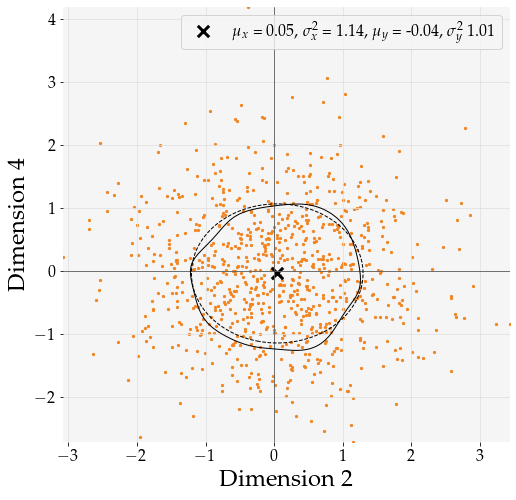

2021-07-30 14:46:21,360 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:21,360 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:21,361 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:21,361 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:21,361 - DEBUG - STREAM b'IDAT' 149 181
2021-07-30 14:46:21,372 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:21,373 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:21,373 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:21,373 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:21,374 - DEBUG - STREAM b'IDAT' 149 111


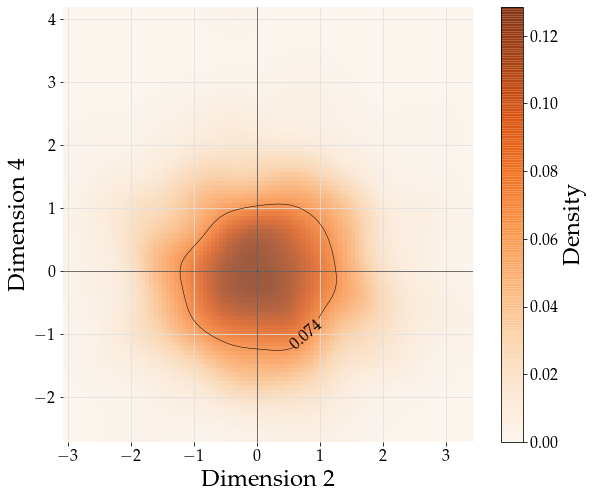

2021-07-30 14:46:21,857 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:21,858 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:21,858 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:21,858 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:21,859 - DEBUG - STREAM b'IDAT' 149 970


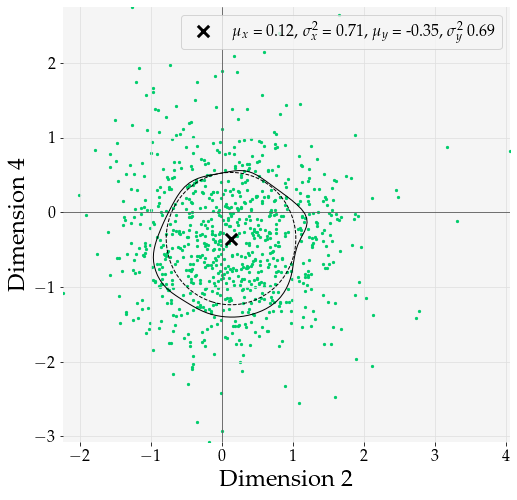

2021-07-30 14:46:22,216 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:22,217 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:22,217 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:22,218 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:22,218 - DEBUG - STREAM b'IDAT' 149 168
2021-07-30 14:46:22,230 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:22,231 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:22,231 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:22,232 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:22,232 - DEBUG - STREAM b'IDAT' 149 118
2021-07-30 14:46:22,234 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:22,234 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:22,235 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:22,235 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:22,236 - DEBUG - STREAM b'IDAT' 149 181
2021-07-30 14:46:22,238 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:22,239 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:22,239 - DEBUG - STREAM b'tRNS' 101 15


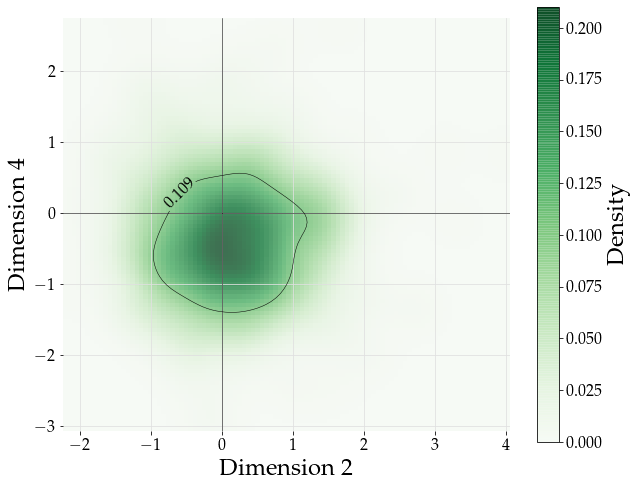

In [5]:
def gaussian2d(x, y, x_mu, x_var, y_mu, y_var):
    arg_x = (x - x_mu)**2 / (2*x_var**2)
    arg_y = (y - y_mu)**2 / (2*y_var**2)    
    return np.exp(-(arg_x + arg_y))

def fwhm(std):
    return 2*np.sqrt(2*np.log(2))*std

# Use standard custom styling
plt.style.use('../../utils/_extras/primary.mplstyle')

def latent_vis_2d(latent_vecs, dim_x: int = 2, dim_y: int = 4, save_name=None, color='C1', show_plots=True):

    # Code for setting up advanced plotting and graphing
    x_mean, x_var = latent_vecs[:, dim_x].mean(), latent_vecs[:, dim_x].var()
    y_mean, y_var = latent_vecs[:, dim_y].mean(), latent_vecs[:, dim_y].var()
    kde = gaussian_kde(latent_vecs[:, [dim_x, dim_y]].T)

    x_steps = np.linspace(latent_vecs[:, dim_x].min(), latent_vecs[:, dim_x].max(), 100)
    y_steps = np.linspace(latent_vecs[:, dim_y].min(), latent_vecs[:, dim_y].max(), 100)
    X, Y = np.meshgrid(x_steps, y_steps)
    Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))



    Zgaussian = gaussian2d(X, Y, x_mean, x_var, y_mean, y_var)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(latent_vecs[:, dim_x], latent_vecs[:, dim_y], s=5, alpha=1., color=color)

    ax.contour(
        X, Y, Zgaussian, levels=[fwhm(Zgaussian.std())], 
        colors='k', linewidths=1., linestyles='--', alpha=1.0)
    ax.contour(
        X, Y, Z.reshape(X.shape), levels=[fwhm(Z.std())], 
        colors='k', linewidths=1., linestyles='-', alpha=1.0)

    ax.scatter([x_mean], [y_mean], color='k', marker='x', s=2**7, 
                label=r'$\mu_x$ = {:.2f}, $\sigma^2_x$ = {:.2f}, $\mu_y$ = {:.2f}, $\sigma^2_y$ {:.2f}'.format(x_mean, x_var, y_mean, y_var))

    ax.axhline(0, 0, c='k', lw=0.5)
    ax.axvline(0, 0, c='k', lw=0.5)
    ax.legend()
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.set_ylabel(f'Dimension {dim_y}')

    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'LatentScatter-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    cb = ax.imshow(Z.reshape(X.shape), cmap='Oranges' if color=='C6' else 'Greens', 
              extent=[x_steps[0], x_steps[-1], y_steps[0], y_steps[-1]], origin='lower', alpha=0.75)
    c = ax.contour(X, Y, Z.reshape(X.shape), colors='k', levels=[fwhm(Z.std())], linewidths=0.5)

    ax.axhline(0, 0, c='k', lw=0.5)
    ax.axvline(0, 0, c='k', lw=0.5)
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.set_ylabel(f'Dimension {dim_y}')
    ax.clabel(c, fontsize=16)
    
    cb = fig.colorbar(cb)
    cb.set_label('Density')
    
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'LatentKDE-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()
    
for sn, res in result_catalog.items():
    lt_vecs = np.stack(res['latent_vecs'], axis=0)
    color = 'C1' if 'AAE' in sn else 'C6'
    latent_vis_2d(lt_vecs, save_name=sn, color=color)

2021-07-30 14:46:23,145 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:23,146 - DEBUG - STREAM b'PLTE' 41 45
2021-07-30 14:46:23,146 - DEBUG - STREAM b'tRNS' 98 14
2021-07-30 14:46:23,146 - DEBUG - STREAM b'pHYs' 124 9
2021-07-30 14:46:23,147 - DEBUG - STREAM b'IDAT' 145 66
2021-07-30 14:46:23,154 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:23,155 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:23,155 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:23,156 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:23,156 - DEBUG - STREAM b'IDAT' 149 356
2021-07-30 14:46:23,169 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:23,169 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:23,169 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:23,170 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:23,170 - DEBUG - STREAM b'IDAT' 149 351
2021-07-30 14:46:23,181 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:23,182 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:23,182 - DEBUG - STREAM b'tRNS' 101 15
20

<Figure size 864x864 with 0 Axes>

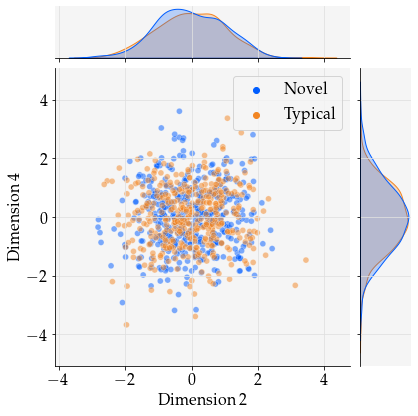

2021-07-30 14:46:23,644 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:23,645 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:23,645 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:23,645 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:23,646 - DEBUG - STREAM b'IDAT' 149 200
2021-07-30 14:46:23,651 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:23,652 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:23,652 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:23,653 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:23,653 - DEBUG - STREAM b'IDAT' 149 320
2021-07-30 14:46:23,658 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:23,659 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:23,659 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:23,659 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:23,660 - DEBUG - STREAM b'IDAT' 149 268


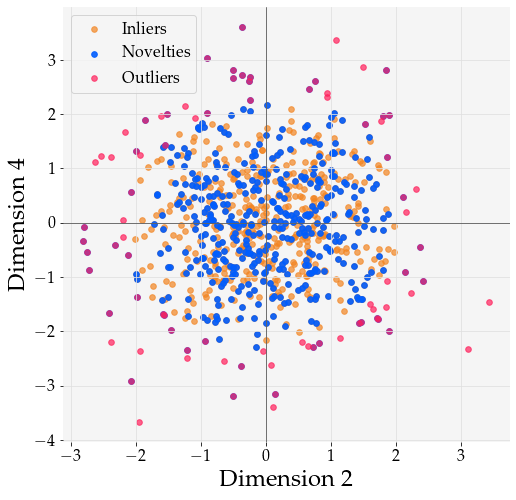

2021-07-30 14:46:24,025 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:24,026 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:24,026 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:24,026 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:24,027 - DEBUG - STREAM b'IDAT' 149 139
2021-07-30 14:46:24,030 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:24,030 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:24,030 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:24,031 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:24,031 - DEBUG - STREAM b'IDAT' 149 149
2021-07-30 14:46:24,033 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:24,034 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:24,034 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:24,034 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:24,035 - DEBUG - STREAM b'IDAT' 149 142
2021-07-30 14:46:24,037 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:24,037 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:24,037 - DEBUG - STREAM b'tRNS' 101 15


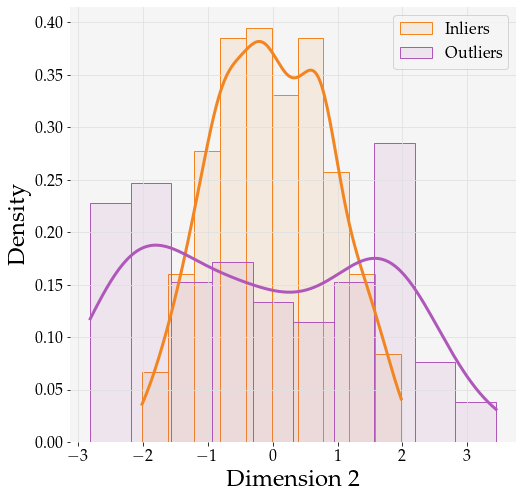

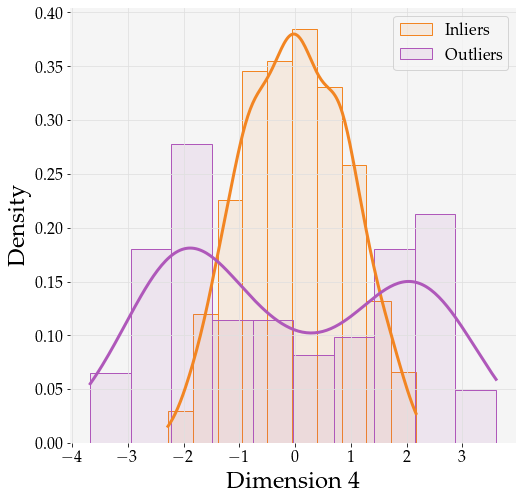

<Figure size 864x864 with 0 Axes>

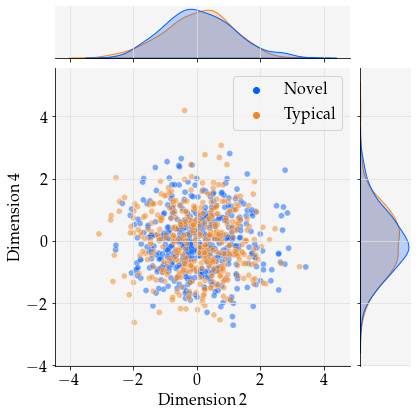

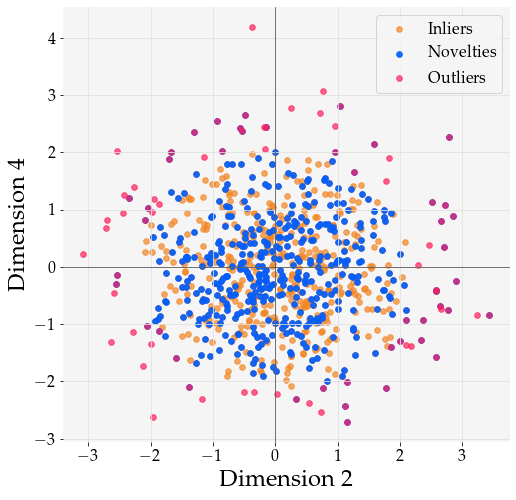

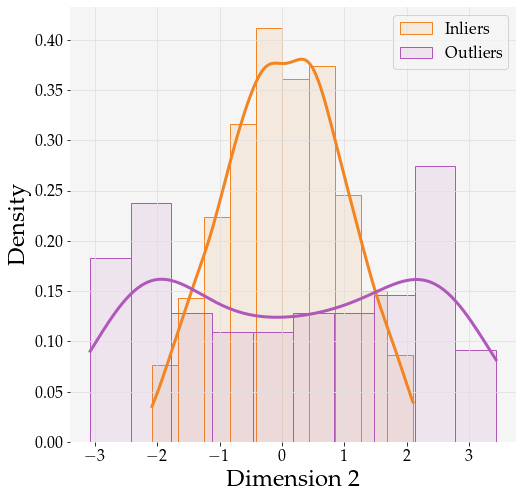

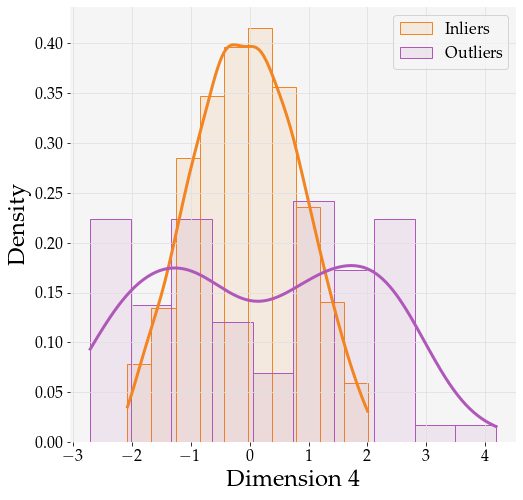

<Figure size 864x864 with 0 Axes>

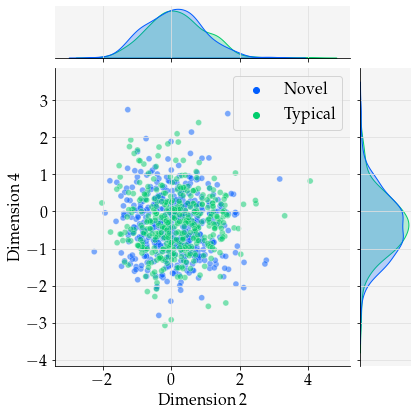

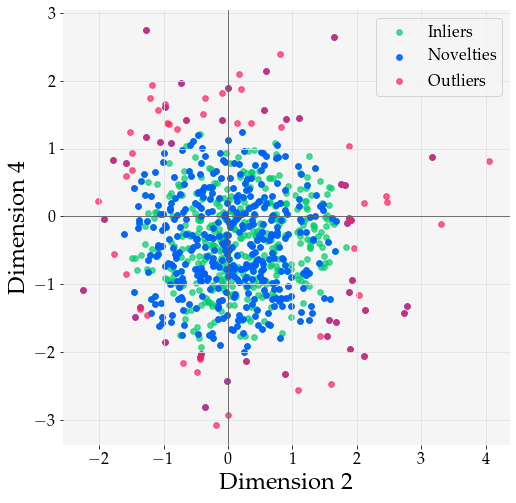

2021-07-30 14:46:28,217 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:28,218 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:28,218 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:28,218 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:28,219 - DEBUG - STREAM b'IDAT' 149 96
2021-07-30 14:46:28,221 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:28,221 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:28,221 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:28,222 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:28,222 - DEBUG - STREAM b'IDAT' 149 98
2021-07-30 14:46:28,224 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:28,225 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:28,225 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:46:28,225 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:46:28,226 - DEBUG - STREAM b'IDAT' 149 129
2021-07-30 14:46:28,227 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:46:28,228 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:46:28,228 - DEBUG - STREAM b'tRNS' 101 15
20

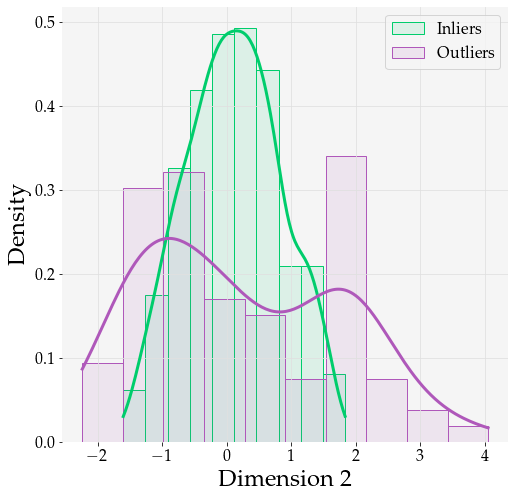

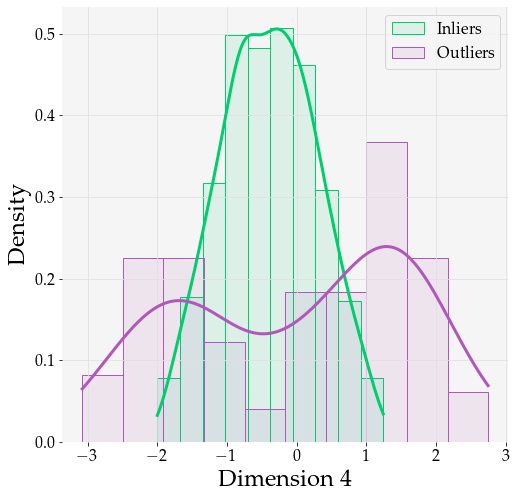

In [6]:
def latent_vis_envelope_2d(latent_vecs, labels, dim_x: int = 2, dim_y: int = 4, save_name=None, stat='density', color='C1'):

    dim_x = 2
    dim_y = 4
    cov_2d = EllipticEnvelope(random_state=49).fit(latent_vecs[:, [dim_x, dim_y]])
    pred_2d = cov_2d.predict(latent_vecs[:, [dim_x, dim_y]])

    inliers_2d = ((pred_2d + 1) // 2).astype(bool)
    outliers_2d = ~inliers_2d
    
    text_labels = []
    for lb in np.array(labels):
        if lb == 0:
            text_labels.append('Typical')
        elif lb == 1:
            text_labels.append('Novel')
        else:
            raise ValueError
    
    # Setup some long form data
    dat = pd.DataFrame.from_dict({
        'Label': np.array(text_labels),
        'x': latent_vecs[:, dim_x],
        'y': latent_vecs[:, dim_y]
    })
    
    fig = plt.figure(figsize=(12, 12))
    h = sns.jointplot(data=dat, x='x', y='y', 
                      hue='Label', kind='scatter', palette=['C5', color], 
                      alpha=0.5, legend=True)
    h.set_axis_labels(f'Dimension {dim_x}', f'Dimension {dim_y}', fontsize=16)
    h.ax_joint.legend(title='')
    plt.savefig(f'JointPlotScatter-{sn}.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    # Plot the 2d results
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(latent_vecs[inliers_2d, dim_x], latent_vecs[inliers_2d, dim_y], s=2**5, 
               label='Inliers', color=color, alpha=0.7)
    # Novelies plotted here
    ax.scatter(latent_vecs[np.array(labels).astype(bool), dim_x], latent_vecs[np.array(labels).astype(bool), dim_y],
               s=2**5, label='Novelties', color='C5', alpha=0.9)  # This line is for seeing the distr. of novelties
    ax.scatter(latent_vecs[outliers_2d, dim_x], latent_vecs[outliers_2d, dim_y], s=2**5,
               label='Outliers', color='C0', alpha=0.7)


    
    ax.axhline(0, 0, c='k', lw=0.5)
    ax.axvline(0, 0, c='k', lw=0.5)
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.set_ylabel(f'Dimension {dim_y}')
    ax.legend()
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'2dOutliers-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()

    # Plot x dimension
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(data=latent_vecs[inliers_2d, dim_x], bins=10, alpha=0.1, stat=stat, 
                 kde=True, color=color, edgecolor=color, label='Inliers')
    sns.histplot(data=latent_vecs[outliers_2d, dim_x], bins=10, alpha=0.1, stat=stat,
                 kde=True, color='C3', edgecolor='C3', label='Outliers')
    
    ax.set_xlabel(f'Dimension {dim_x}')
    ax.legend()
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'InlierOutlierDensityX-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()

    # Plot y dimension
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(data=latent_vecs[inliers_2d, dim_y], bins=10, alpha=0.1, stat=stat,
                 kde=True, color=color, edgecolor=color, label='Inliers')
    sns.histplot(data=latent_vecs[outliers_2d, dim_y], bins=10, alpha=0.1, stat=stat, 
                 kde=True, color='C3', edgecolor='C3', label='Outliers')
    ax.set_xlabel(f'Dimension {dim_y}')
    ax.legend()
    if save_name is not None and isinstance(save_name, str):
        plt.savefig(f'InlierOutlierDensityY-{save_name}.pdf', format='pdf',  bbox_inches='tight')
    plt.show()
    
    # Here, the negative mahalanobis distance is used as the novelty score
    return -cov_2d.mahalanobis(latent_vecs[:, [dim_x, dim_y]])

# Use the negative Mahalanobis distance as the novelty score
latent_scores_catalog = {}

for sn, res in result_catalog.items():
    lt_vecs = np.stack(res['latent_vecs'], axis=0)
    labels = res['labels']
    color = 'C1' if 'AAE' in sn else 'C6'
    scores_2d = latent_vis_envelope_2d(lt_vecs, labels, save_name=sn, color=color)
    latent_scores_catalog[f'{sn}-2d'] = scores_2d

2021-07-30 14:53:24,651 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:53:24,652 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:53:24,652 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:53:24,653 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:53:24,653 - DEBUG - STREAM b'IDAT' 149 109
2021-07-30 14:53:24,666 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:53:24,667 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:53:24,667 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:53:24,668 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:53:24,668 - DEBUG - STREAM b'IDAT' 149 518
2021-07-30 14:53:24,678 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:53:24,679 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:53:24,679 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:53:24,679 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:53:24,680 - DEBUG - STREAM b'IDAT' 149 137
2021-07-30 14:53:24,692 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:53:24,693 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:53:24,693 - DEBUG - STREAM b'tRNS' 101 15


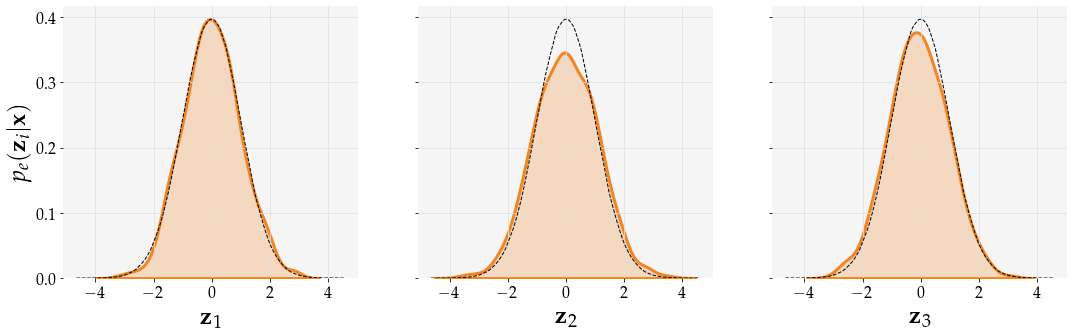

In [ ]:
def latent_vis_envelope_nd(latent_vecs, dim_x: int = 2, dim_y: int = 4, save_name=None, color='C1'):

    cov = EllipticEnvelope(random_state=49).fit(latent_vecs)

    pred = cov.predict(latent_vecs)
    standard_normal = np.random.normal(0., 1., 1000000)

    inliers = ((pred + 1) // 2).astype(bool)
    outliers = ~inliers

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18,5))
    sns.kdeplot(ax=ax[0], data=standard_normal, color='k', lw=1, ls='--')
    sns.kdeplot(ax=ax[0], data=latent_vecs[:, 3], fill=True, lw=3, color=color)
    ax[0].set_ylabel('$p_{e}(\\mathbf{z}_i|\\mathbf{x})$')
    ax[0].set_xlabel('$\\mathbf{z}_1$')
    
    sns.kdeplot(ax=ax[1], data=standard_normal, color='k', lw=1, ls='--')
    sns.kdeplot(ax=ax[1], data=latent_vecs[:, 4], fill=True, lw=3, color=color)
    ax[1].set_xlabel('$\\mathbf{z}_2$')
    
    sns.kdeplot(ax=ax[2], data=standard_normal, color='k', lw=1, ls='--')
    sns.kdeplot(ax=ax[2], data=latent_vecs[:, 5], fill=True, lw=3, color=color)
    ax[2].set_xlabel('$\\mathbf{z}_3$')
    plt.show()
    
    # Here, the negative mahalanobis distance is used as the novelty score
#     return -cov.mahalanobis(latent_vecs)
    return cov.score_samples(latent_vecs)
    
for sn, res in result_catalog.items():
    lt_vecs = np.stack(res['latent_vecs'], axis=0)
    color = 'C1' if 'AAE' in sn else 'C6'
    scores_nd = latent_vis_envelope_nd(lt_vecs, save_name=sn, color=color)
    latent_scores_catalog[f'{sn}-nd'] = scores_nd

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

for sn in result_catalog:
    
    if 'v1' not in sn:
        continue
    
    for suf in ['2d', 'nd']:
        scores = latent_scores_catalog[f'{sn}-{suf}']
        fpr, tpr, thresholds, auc = metrics.roc(scores, result_catalog[sn]['labels'])

        ax.plot(fpr, tpr, label=f'{sn.split("-")[0]}-{suf}: {auc:.2f}')
    

ax.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random: 0.5')
ax.legend(title='AUC')#, bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.axhline(0, 0, c='k', lw=1)
ax.axvline(0, 0, c='k', lw=1)

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

plt.savefig('ROC-latentspace_LunarAnalogueLandscape.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
print(latent_scores_catalog.keys())

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

for sn in result_catalog:
    
    if 'v1' not in sn:
        continue
    
    for suf in ['2d', 'nd']:
        scores = latent_scores_catalog[f'{sn}-{suf}']


        pak = metrics.precision_at_k(scores, result_catalog[sn]['labels'])

        uniques, counts = np.unique(result_catalog[sn]['labels'], return_counts=True)
        random = counts.min() / counts.sum()
        pat15 = int(0.15 * counts.sum())

        ax.plot(pak, label=f'{sn.split("-")[0]}-{suf}: {pak[int(sum(result_catalog[sn]["labels"]))]:.2f} / {pak[pat15]:.2f}')
    
ax.plot([0, len(pak)], [random, random], 'k:', lw=2, 
        label='$k_{\mathrm{novel}}/k_{\mathrm{total}}$: '+f'{counts[1]/counts.sum():.2f}')

ax.set_xlabel('$k$')
ax.set_ylabel('Precision($k$)')
ax.legend(title='Precision($k_{\mathrm{novel}}$) / Precision(15\%)')#, bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.set_xticks([pat15, counts[1], counts.sum()])
ax.set_xticklabels(['15\%', '$k_{\mathrm{novel}}$', counts.sum()])

# Draw axes for styling
ax.axhline(0, 0, c='k', lw=0.5)
ax.axvline(0, 0, c='k', lw=0.5)

plt.savefig('Pak-latentspace_LunarAnalogueLandscape.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
def score_density_vis_lt(lt_scores,labels, sn, color='C1'):
    
    labels = np.array(labels).astype(bool)

    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(data=lt_scores[labels], label='Novel', color='C5', fill=True, lw=0, alpha=0.3, kde=True)
    sns.histplot(data=lt_scores[~labels], label='Typical', color=color, fill=True, lw=0, alpha=0.3, kde=True)
    ax.set_xlabel('Novelty Score, $S_{x,i}$')
    plt.legend()
    plt.savefig(f'LatentScoreDensity-{sn}-CuriosityMastcam.pdf', format='pdf', bbox_inches='tight')
    plt.show()

for sn, res in result_catalog.items():
    print(latent_scores_catalog.keys())
            
    lt_scores = latent_scores_catalog[f'{sn}-nd']
    lt_scores = np.array(lt_scores)
    
    # Scale novelty scores between 0,1, though it doesn't really matter
    lt_scores /= np.max(np.abs(lt_scores))
    lt_scores += 1
    if 'AAE' in sn:
        color = 'C1'
    elif 'VAE' in sn:
        color='C6'
    score_density_vis_lt(lt_scores, res['labels'], sn, color=color)